In [1]:
# Import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# Generate Phantom and Display
    # Parameters:
        # (x,y) resolution
        # Length (real world)
        # attenuation values
        # speed values
def generate_phantom (x,y,length,attenuations, speeds):

    # Create phantom matrix, U matrix, L matrix
    phantom = np.zeros((y,x), np.uint8) # phantom image
    U = np.zeros((y,x), np.float32) # attenuation matrix
    S = np.zeros((y,x), np.float32) # speed matrix
    L = np.ones((y,x), np.float32) # length matrix
    L = L * length / x # how many cm per pixel


    # Phantom will have 4 structures
    # Structures will have relative positions
    #Rectangle (Human Body)
    
    struct_1 = np.zeros((y, x), np.float32)
    struct_2 = np.zeros((y, x), np.float32)
    struct_3 = np.zeros((y, x), np.float32)
    struct_4 = np.zeros((y,x), np.float32)
    
    #struct_1[int(y*0.1):int(y*0.9),int(x*0.15):int(x*0.9)] = 20
    #-----------------------------------------------------
    #-------------Organ Structure------------------------
    #top side of rectangle
    a = 1
    for i in range(int(y * 0.4), int(y * 0.2), -1):
        struct_2[i][int(x * 0.4):int(x * 0.6) - a] = 100
        a = a + 1
    
    #middle square
    struct_3[int(y * 0.4):int(y * 0.6), int(x * 0.4):int(x * 0.6)] = 100
    
    #botton part
    b = 1
    for i in range(int(y * 0.6), int(y * 0.8)):
        struct_4[i][int(x * 0.4):int(x * 0.6) - b] = 100
        b = b + 1
    #----------------------------------------------------------

    # Add the structures to the phantom
    phantom += struct_1.astype(np.uint8) + struct_2.astype(np.uint8) + struct_3.astype(np.uint8) + struct_4.astype(np.uint8)
    phantom *= 255

    # Write a phantom
    cv2.imwrite("phantom.jpg", phantom)

    # Add structure attenuations to U matrix
    U += struct_1 * attenuations[0] + struct_2 * attenuations[0] + struct_3 * attenuations[0] + struct_4 * attenuations[0]
    U[np.where(U == 0)] = attenuations[1]
    
    # Add structure speeds to S matrix
    S += struct_1 * speeds[0] + struct_2 * speeds[0] + struct_3 * speeds[0] + struct_4 * speeds[0]
    S[np.where(S == 0)] = speeds[1]

    return phantom, U, S, L

In [3]:
# Create a virtual Sensor
def run_ultrasound(sensor_resolution,i_0, U, S, L):
    # Get Intensities
    us = compute_echoes(i_0, U, S, L)
    us = us/ np.amax(us)
    print(us)
    #map to sensor resolution
    return us

In [4]:
# Compute the echoes from the ultrasound
def compute_echoes(i_0,U, S, L):
    echoes = np.zeros(U.shape)  
    for i in range(U.shape[0]):
        for j in range(U.shape[1] -2):
              echoes[i,j] = S[i,j]* np.exp(-0.3* U[i,j]*L[i,j]*j)
    return echoes

In [5]:
# Show the ultrasound
def save_ultrasound(us):
    cv2.imwrite("ultrasound.jpg", normalize_image(us))

In [6]:
def normalize_image(us):
    min_val = np.min(us)
    max_val = np.max(us)
    return (us - min_val)*(255/(max_val-min_val))

[[1.         0.99363363 0.9873078  ... 0.03874165 0.         0.        ]
 [1.         0.99363363 0.9873078  ... 0.03874165 0.         0.        ]
 [1.         0.99363363 0.9873078  ... 0.03874165 0.         0.        ]
 ...
 [1.         0.99363363 0.9873078  ... 0.03874165 0.         0.        ]
 [1.         0.99363363 0.9873078  ... 0.03874165 0.         0.        ]
 [1.         0.99363363 0.9873078  ... 0.03874165 0.         0.        ]]


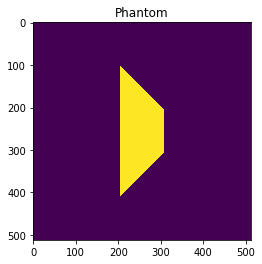

In [7]:
# Phantom Parameters
x = 512 # pixels
y = 512 # pixels
length = 10 # cm

attenuations = np.zeros(2)
attenuations[0] = 0.48 ## fat
attenuations[1] = 1.09 ## muscle

## specific speed (m/sec)
speeds = np.zeros(2)
speeds[0] = 1460 ## fat
speeds[1] = 1580 ## muscle

# Get phantom and matrices
phantom, U, S, L = generate_phantom(x,y,length,attenuations, speeds)

#US parameters 
sensor_resolution = 16
i_0 = 60

# Display phantom
%matplotlib inline

plt.figure(0)
plt.title("Phantom")
plt.imshow(phantom)

# Compute ultrasound
us = run_ultrasound(sensor_resolution, i_0, U, S, L)
    

In [8]:
# Display graphs
save_ultrasound(us)